In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from collections import Counter
import seaborn as sns

In [ ]:
# Cleaning up the data (don't run bc I already cleaned up the data: "cleaned_pinterest.csv")

# Load CSV
df = pd.read_csv('/Users/amiechoe/Desktop/pinterest_proj/df_pinterest.csv')

# Clean column names just in case
df.columns = df.columns.str.strip().str.lower()

# Ensure 'id' is a string
df['id'] = df['id'].astype(str)

# Replace blank strings with NaN
df = df.replace(r'^\s*$', np.nan, regex=True)

# Parse like_count safely
def parse_count(x):
    if pd.isna(x) or str(x).strip() == '':
        return 0.0
    try:
        x = str(x).strip().lower()
        if 'k' in x:
            return float(x.replace('k', '')) * 1000
        return float(x)
    except ValueError:
        return 0.0

df['like_count'] = df['like_count'].apply(parse_count).fillna(0).astype(int)

# Convert other numeric columns
df['repin_count'] = pd.to_numeric(df['repin_count'], errors='coerce').fillna(0).astype(int)
df['comment_count'] = pd.to_numeric(df['comment_count'], errors='coerce').fillna(0).astype(int)


# Drop rows ONLY IF all three fields are missing or 0
df = df[~(
    (df['category'].isna()) &
    (df['like_count'] == 0) &
    (df['comment_count'] == 0)
)]

# Save the cleaned DataFrame to your Desktop
output_path = '/Users/amiechoe/Desktop/cleaned_pinterest.csv'
df.to_csv(output_path, index=False)

print(f"Cleaned dataset saved to: {output_path}")

FileNotFoundError: [Errno 2] No such file or directory: '/Users/amiechoe/Desktop/pinterest_proj/df_pinterest.csv'

In [2]:
# loading in new, cleaned dataset

df1 = pd.read_csv('/Users/amiechoe/Desktop/pinterest_proj/cleaned_pinterest.csv')

image_directory = '/Users/amiechoe/Desktop/pinterest_proj/images'

In [ ]:
# STEP 1:


# extracing top "x" dominant colors from each image

# opens each image, resizes it, reshapes the pixels into a falt 2D array of RGB values
# applies K-Means clustering to find "k" dominant color clusters
# returns the RGB values of the cluster centers and the pixel labels

def extract_dominant_colors(image, k = 3):
    img = Image.open(image).convert("RGB").resize((100, 100))
    pixels = np.array(img).reshape(-1, 3)
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pixels)
    return kmeans.cluster_centers_.astype(int), kmeans.labels_



# loops through each row of df1, tries to find the corresponding image file
# if found, extracts 3 RGB colors, flattens them into 9 features (3 arrays, each with 3 values)
# if not found, adds a fallback row of zeros

color_features = []

for idx, row in df1.iterrows():
    image_ID = row['id']
    image_path = os.path.join(image_directory, f"{image_ID}.jpg")
    if os.path.exists(image_path):
        centers, _ = extract_dominant_colors(image_path, k=3)
        color_features.append(centers.flatten())
    else:
        color_features.append([0] * 9)  # fallback if image missing


In [4]:
# STEP 2:

# creates new Dataframe ("df_color") with 9 columns (color_0 to color_8) reresenting the 3 RGB colors
# concatenates it with my original DataFrame to make "df_combined"

df_color = pd.DataFrame(color_features, columns=[f"color_{i}" for i in range(9)])
df_combined = pd.concat([df1.reset_index(drop=True), df_color], axis=1)

# df_combined contains:
# all og data from CSV (id, repin, like count)
# 9 new columns for dominant color values

In [5]:
# STEP 3

# normalizes the 9 color values using StandardScalar for more effective clustering
# 9 color features (RGB values) have values from 0 to 255
# k means works best when all feautures are on the same scale
# this makes sure red, green, blue values contribute equally to the clustering, 

scaler = StandardScaler()
color_scaled = scaler.fit_transform(df_color)


# performs K-Means clustering again-- this time to group images based on their color profiles (10 overall clusters)
kmeans_scheme = KMeans(n_clusters=10, random_state=42)
df_combined['color_scheme_cluster'] = kmeans_scheme.fit_predict(color_scaled)


cluster_labels = {
    0: "Autumn Shades & Vibrant Accents",
    1: "Forest & Earthy Colors",
    2: "Rustic Autumn with Bold Accents",
    3: "Smoky Naturals & Soft Army Tones",
    4: "Cool Slate & Soft Evergreen",
    5: "Muted Reds and Neutrals",
    6: "Warm Pinks & Clay Neutrals",
    7: "Clean Neutrals & Minimalist Tones",
    8: "Moody Stone & Deep Greens",
    9: "Pastel Blush & Soft Whites"
}

df_combined['color_theme_label'] = df_combined['color_scheme_cluster'].map(cluster_labels)

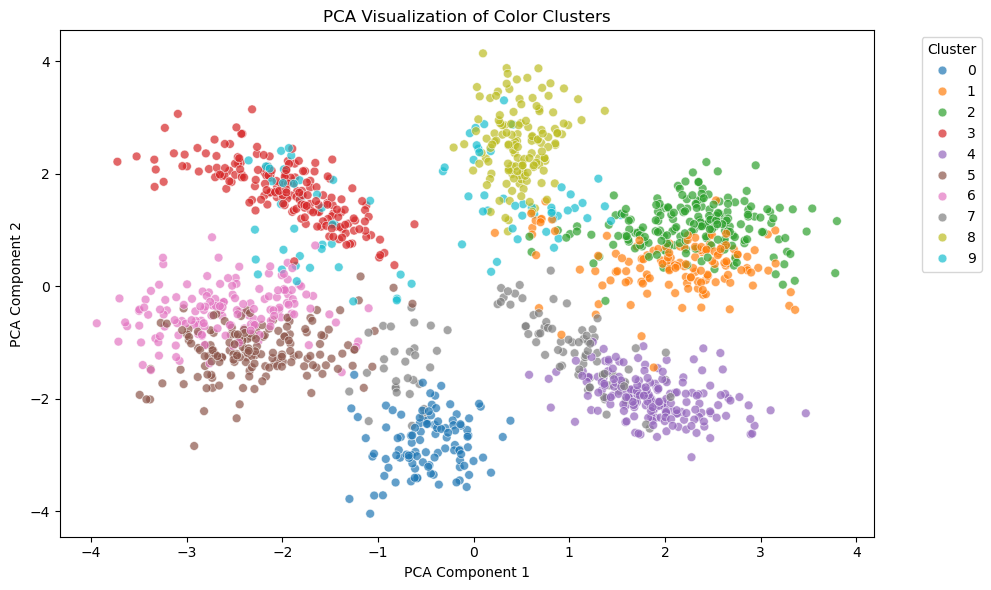

In [6]:
# STEP 4:


# reduces 9-dimensional color data into 2 dimensions for visualization using PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(color_scaled)

df_combined['pca1'] = pca_result[:, 0]
df_combined['pca2'] = pca_result[:, 1]


plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_combined,
    x='pca1',
    y='pca2',
    hue='color_scheme_cluster',
    palette='tab10',
    s=40,
    alpha=0.7
)
plt.title("PCA Visualization of Color Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


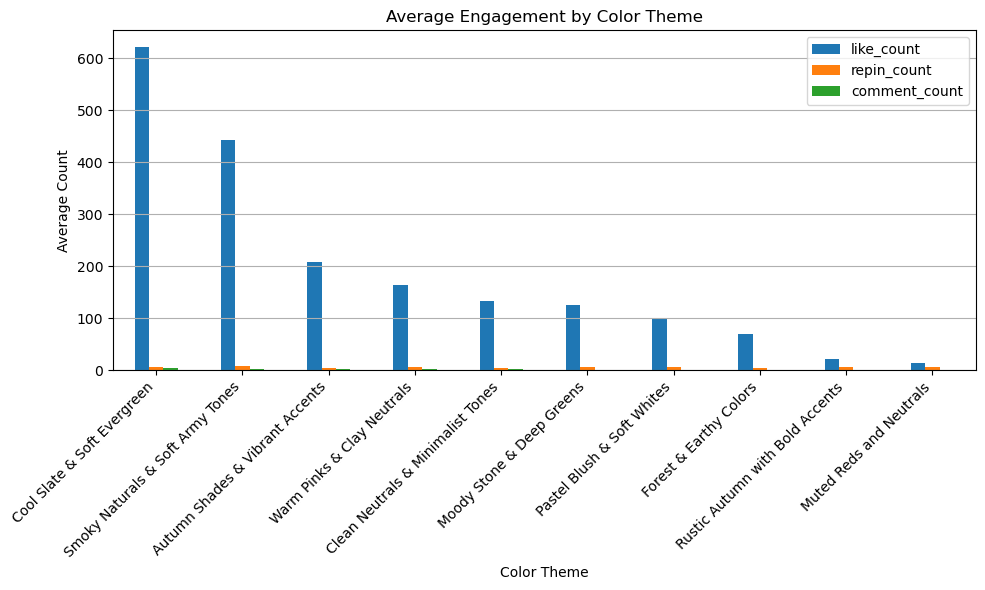

In [7]:
# STEP 5: 

# makes sure engagement columns are numeric for averaging
theme_engagement = df_combined.groupby('color_theme_label')[['like_count', 'repin_count', 'comment_count']].mean()
theme_engagement_sorted = theme_engagement.sort_values(by='like_count', ascending=False)


# groups data by color cluster and computes average repins, likes, and comments

# plots the result as a bar chart showing which color-themed image clusters get the most engagement

theme_engagement_sorted.plot(kind='bar', figsize=(10, 6))
plt.title("Average Engagement by Color Theme")
plt.ylabel("Average Count")
plt.xlabel("Color Theme")
plt.grid(axis='y')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [8]:
# checking how many images are in each of the 10 clusters
df_combined['color_scheme_cluster'].value_counts().sort_index()

color_scheme_cluster
0    104
1    143
2    192
3    188
4    190
5    167
6    148
7    105
8    137
9     85
Name: count, dtype: int64

In [9]:
##  Optional: just to check and visualize color palettes

# Define the visualization function
def show_image_and_palette(row, image_dir, num_colors=5):
    image_id = row['id']
    image_path = os.path.join(image_dir, f"{image_id}.jpg")
    
    # Show image:

    # if os.path.exists(image_path):
    #     img = Image.open(image_path)
    #     plt.figure(figsize=(4, 4))
    #     plt.imshow(img)
    #     plt.title(f"Image ID: {image_id} | Cluster {row['color_scheme_cluster']}")
    #     plt.axis('off')
    #     plt.show()
    # else:
    #     print(f"Image not found: {image_path}")
    

    # Show palette
    colors = []
    for i in range(num_colors):
        r = row[f'color_{i*3}']
        g = row[f'color_{i*3 + 1}']
        b = row[f'color_{i*3 + 2}']
        colors.append([r, g, b])
    
    colors = np.array(colors, dtype=np.uint8).reshape(1, num_colors, 3)
    plt.figure(figsize=(num_colors, 1))
    plt.imshow(colors)
    plt.axis('off')
    plt.show()

CLUSTER 0


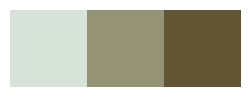

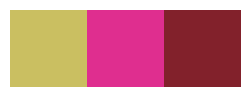

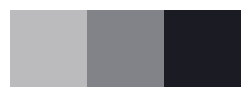

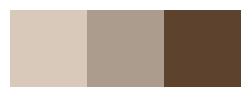

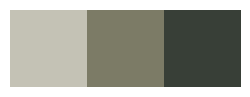

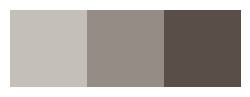

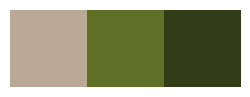

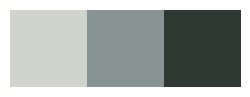

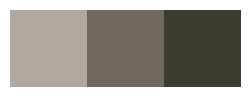

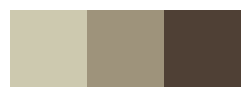

CLUSTER 1


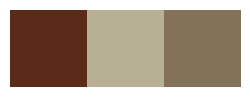

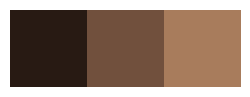

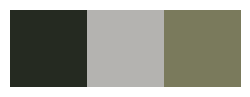

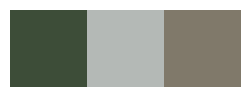

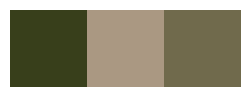

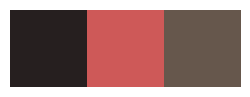

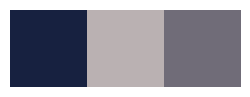

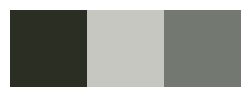

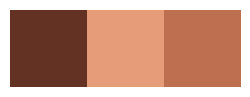

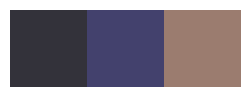

CLUSTER 2


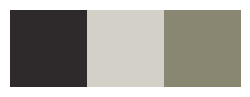

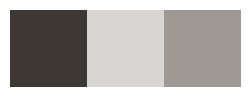

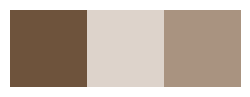

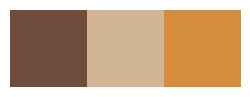

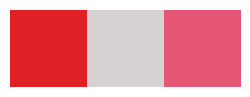

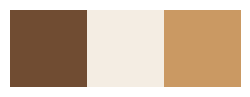

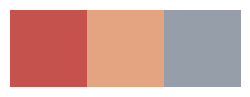

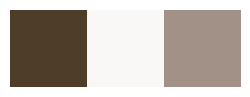

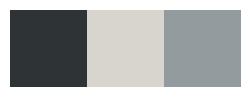

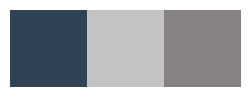

CLUSTER 3


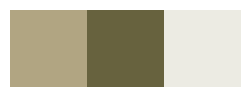

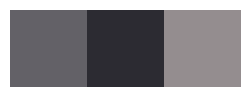

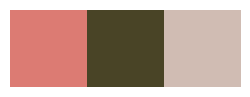

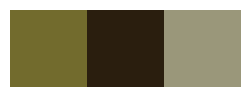

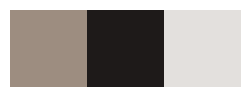

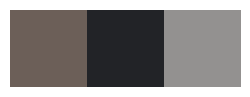

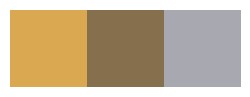

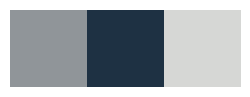

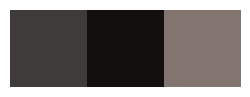

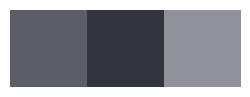

CLUSTER 4


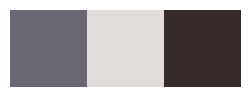

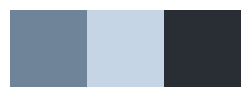

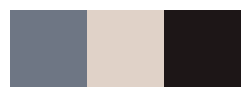

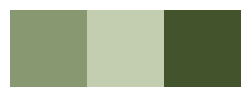

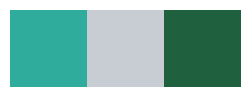

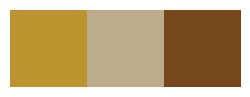

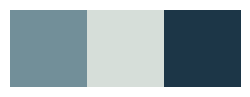

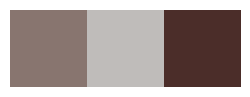

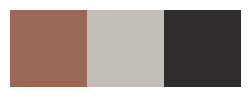

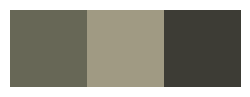

CLUSTER 5


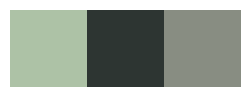

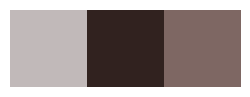

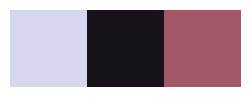

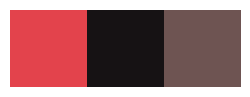

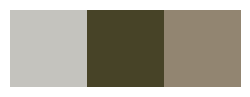

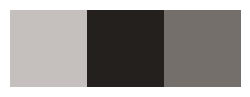

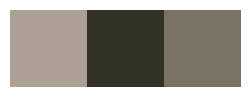

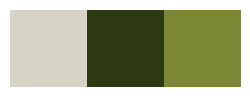

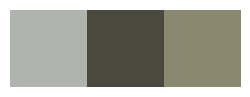

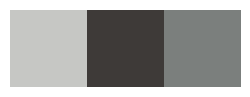

CLUSTER 6


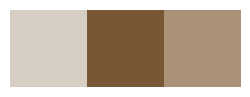

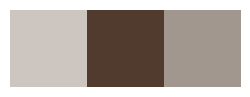

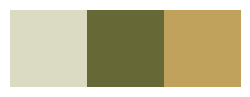

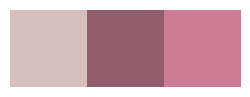

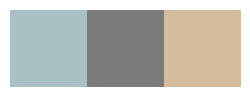

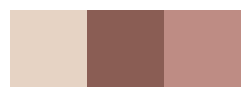

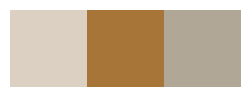

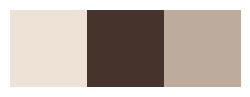

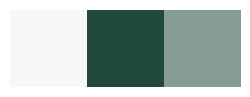

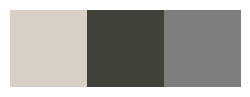

CLUSTER 7


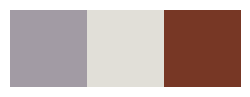

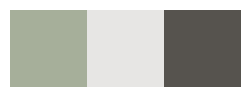

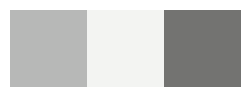

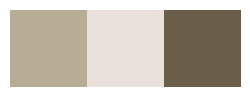

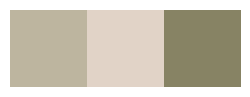

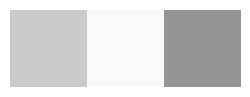

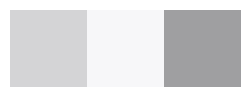

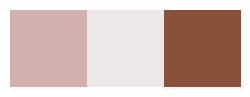

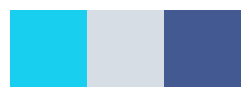

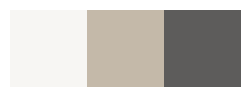

CLUSTER 8


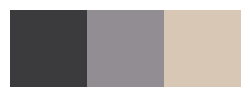

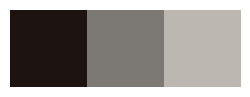

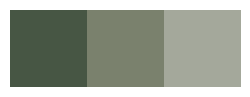

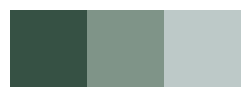

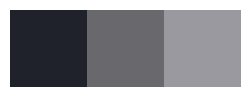

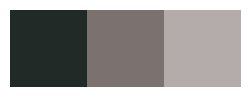

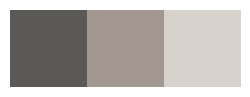

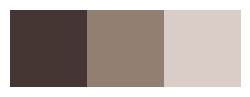

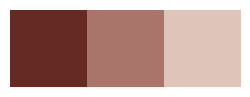

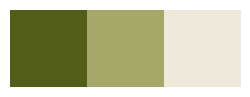

CLUSTER 9


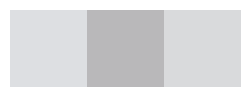

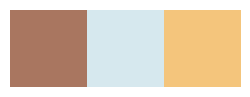

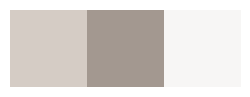

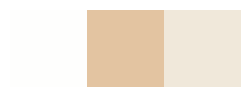

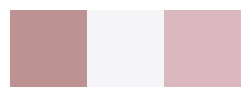

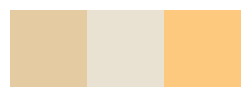

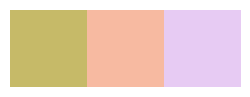

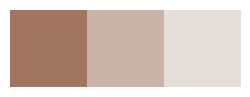

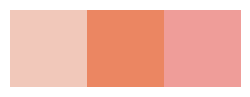

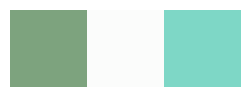

In [10]:
# Show multiple sample images per cluster to inspect color themes
images_per_cluster = 10  # you can increase or decrease this number

for cluster_id in range(10):
    print(f"CLUSTER {cluster_id}")
    sample = df_combined[df_combined['color_scheme_cluster'] == cluster_id].sample(images_per_cluster, random_state=cluster_id)
    for _, row in sample.iterrows():
        show_image_and_palette(row, image_directory, num_colors = 3)
